# NLP With Deep Learning (W266)

Submission by *Carolina Arriaga, Ayman, Abhi Sharma*

Winter 2021 | UC Berkeley

## Notebook Overview

This notebook contains the variable summary length analysis done by the team on dimension scores

# Utils

In [1]:
import datetime
from google.colab import files
from os import listdir
from os.path import isfile, join

def write_to_csv(df, inner_filename):
  now = datetime.datetime.now()
  filename = now.strftime("%Y-%m-%d-%H-%M-%S")

  compression_opts = dict(method='zip', archive_name='{}.csv'.format(inner_filename))

  df.to_csv('{}.zip'.format(filename), index=False, compression = compression_opts)
  files.download('{}.zip'.format(filename))

def download_all_imgs():
  imgs = [f for f in listdir('/content') if isfile(join('/content', f))]
  imgs = [p for p in imgs if p.endswith('png') or p.endswith('jpg') or p.endswith('jpeg')]
  print(imgs)
  for p in imgs:
    files.download(p)

# Data Prep

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost
import os
import matplotlib.pyplot as plt
import copy

In [3]:
# load data, create X, y train test
train_df = pd.read_csv('analysis_shap_analysis.csv')
X_train = train_df.drop(['id', 'model_id', 'model_variant', 'expert_coherence_avg', 'expert_consistency_avg', 'expert_fluency_avg',
             'expert_relevance_avg', 'top_sim_original_encoded', 'top_sim_encoded_reference'], axis=1)
info_train = train_df[['id', 'model_id', 'model_variant']]


test_df = pd.read_csv('data_scored_with_top_tranmatrix.csv')
info_test = test_df[['story_id', 'model_id', 'model_variant', 'decoded', 'reference', 'expected_token_count_decoded', 'word_count_decoded', 'word_count_reference']]
test_df_x_cols = [c for c in test_df if c in list(X_train.columns)]
assert(len([c for c in list(X_train.columns) if c not in test_df_x_cols])) == 0
assert (sorted(test_df_x_cols) == sorted(list(X_train.columns)))


# Model Prep and Run


In [4]:
def get_model(X, y, dim):
    # train test split
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

    # create model
    model = xgboost.XGBRegressor(objective='reg:squarederror', max_depth=2, learning_rate=0.1,
                                 n_estimators=6000, n_jobs=15, base_score=np.mean(y_train), subsample=0.7,
                                 colsample_bytree=0.9, reg_lambda=50)

    # fit model
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)],
              eval_metric=['rmse', 'mae'], early_stopping_rounds=200, verbose=False);

    print('For model dimension: {}, Validation RMSE: {} '.format(dim, np.sqrt(mean_squared_error(y_validation, model.predict(X_validation)))))
    print('For model dimension: {}, Validation MAE: {}'.format(dim, np.sqrt(mean_absolute_error(y_validation, model.predict(X_validation)))))

    return model

In [5]:
model_coherence = get_model(X_train, train_df['expert_coherence_avg'], dim='coherence')
model_fluency = get_model(X_train, train_df['expert_fluency_avg'], dim='fluency')
model_consistency = get_model(X_train, train_df['expert_consistency_avg'], dim='consistency')
model_relevance = get_model(X_train, train_df['expert_relevance_avg'], dim='relevance')

For model dimension: coherence, Validation RMSE: 0.8620904322660526 
For model dimension: coherence, Validation MAE: 0.8321506748507477
For model dimension: fluency, Validation RMSE: 0.6020467639830688 
For model dimension: fluency, Validation MAE: 0.6028286850637329
For model dimension: consistency, Validation RMSE: 0.7987613001604679 
For model dimension: consistency, Validation MAE: 0.640367222528152
For model dimension: relevance, Validation RMSE: 0.6744266474818499 
For model dimension: relevance, Validation MAE: 0.7132871438153934


# Results and Analysis

In [6]:
# column order matters and must match the order with which the model was trained
# https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
test_df_x_cols = model_coherence.get_booster().feature_names
assert (sorted(test_df_x_cols) == sorted(list(X_train.columns)))

coherence_pred = model_coherence.predict(test_df[test_df_x_cols])
fluency_pred = model_fluency.predict(test_df[test_df_x_cols])
consistency_pred = model_consistency.predict(test_df[test_df_x_cols])
relevance_pred = model_relevance.predict(test_df[test_df_x_cols])

# clip values to be between 1 and 5 - though not strictly correct, but we need a way to convert back to likert scale
def get_correct_value(val):
  if val <=1:
    return 1
  if val >=5:
    return 5
  return val

coherence_pred = [get_correct_value(p) for p in coherence_pred]
fluency_pred = [get_correct_value(p) for p in fluency_pred]
consistency_pred = [get_correct_value(p) for p in consistency_pred]
relevance_pred = [get_correct_value(p) for p in relevance_pred]


In [7]:
test_df['coherence_pred'] = coherence_pred 
test_df['fluency_pred'] = fluency_pred 
test_df['consistency_pred'] = consistency_pred 
test_df['relevance_pred'] = relevance_pred 
write_to_csv(test_df, "data_scored_predicted")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Distributions

### Overall

(array([ 8.,  4., 12., 22., 57., 86., 96., 70., 38., 15.]),
 array([2.38836098, 2.64952488, 2.91068878, 3.17185268, 3.43301659,
        3.69418049, 3.95534439, 4.21650829, 4.4776722 , 4.7388361 ,
        5.        ]),
 <a list of 10 Patch objects>)

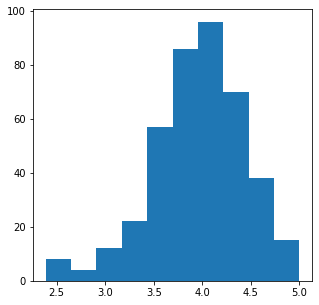

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(coherence_pred)

(array([  1.,   6.,  16.,  14.,  24.,  10.,  26.,  38.,  65., 208.]),
 array([3.42956686, 3.58661017, 3.74365349, 3.9006968 , 4.05774012,
        4.21478343, 4.37182674, 4.52887006, 4.68591337, 4.84295669,
        5.        ]),
 <a list of 10 Patch objects>)

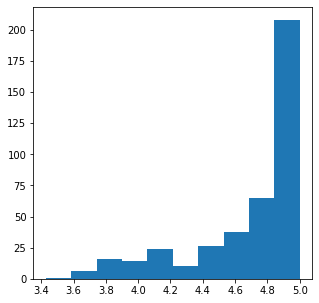

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(fluency_pred)

(array([ 16.,  42.,  19.,   9.,   4.,   1.,  14.,  13.,  34., 256.]),
 array([2.89659333, 3.106934  , 3.31727467, 3.52761533, 3.737956  ,
        3.94829667, 4.15863733, 4.368978  , 4.57931867, 4.78965933,
        5.        ]),
 <a list of 10 Patch objects>)

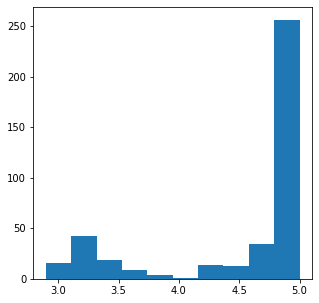

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(consistency_pred)

(array([ 5., 25., 30., 59., 72., 86., 65., 34., 22., 10.]),
 array([1.8863024, 2.158673 , 2.4310439, 2.7034144, 2.9757853, 3.248156 ,
        3.5205266, 3.7928975, 4.065268 , 4.337639 , 4.6100097],
       dtype=float32),
 <a list of 10 Patch objects>)

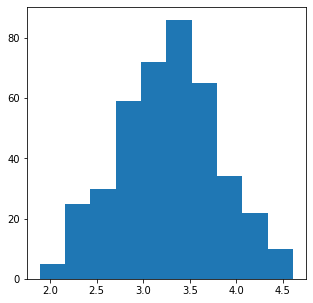

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(relevance_pred)

### Extractive vs Abstractive

In [12]:
extractive = ['topN', 'tfidf_vec', 'cossim_rank', 'bert_ext']
abstractive = ['bart', 't5', 'pegasus', 'gpt3']

def get_model_type(model_name):
  if model_name in extractive:
    return "extractive"
  if model_name in abstractive:
    return "abstractive"
  else:
    raise Exception(model_name) 

assert(sorted(list(test_df['model_id'].unique())) == sorted(extractive + abstractive))

In [13]:
test_df['model_type'] = test_df.apply(lambda row : get_model_type(row['model_id']), axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86636fc390>,
      dtype=object)

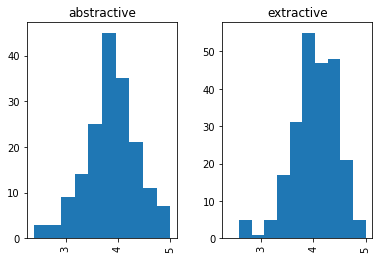

In [14]:
test_df['coherence_pred'].hist(by = test_df['model_type'], sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8663640710>,
      dtype=object)

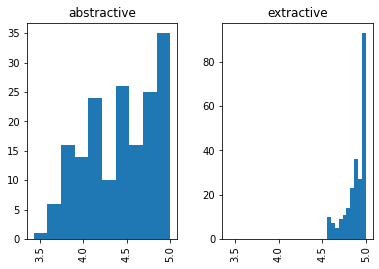

In [15]:
test_df['fluency_pred'].hist(by = test_df['model_type'], sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86635eacd0>,
      dtype=object)

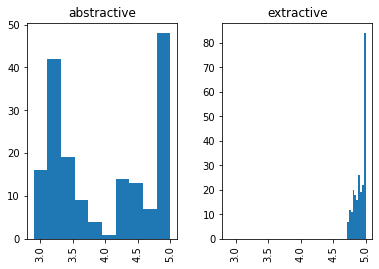

In [16]:
test_df['consistency_pred'].hist(by = test_df['model_type'], sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f866346f0d0>,
      dtype=object)

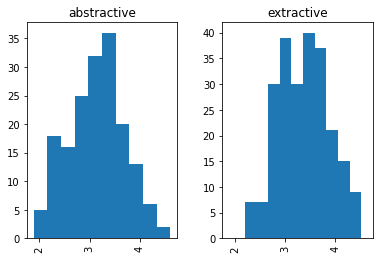

In [17]:
test_df['relevance_pred'].hist(by = test_df['model_type'], sharex=True)

## Sample BAD Summaries

In [18]:
def get_sample_rows_below_dim(df, dim, dim_threshold=3, num_rows=1):
  for idx, row in df.loc[df[dim] < dim_threshold].sample(n=num_rows).iterrows():
    print_row(row)

def get_sample_rows_above_dim(df, dim, dim_threshold=4.5, num_rows=1):
  for idx, row in df.loc[df[dim] >= dim_threshold].sample(n=num_rows).iterrows():
    print_row(row)

def print_row(row):
  print("REF: {}".format(row['reference']))
  print()
  print("DECODED: {}".format(row['decoded']))
  print()
  print("MODEL: {}-{}".format(row['model_id'], row['model_variant']))
  print("####################################################################")
  print()

In [19]:
get_sample_rows_below_dim(test_df, 'coherence_pred', dim_threshold=3, num_rows=1)

REF: "There has been an unusually high number of sea lions stranded since January," NOAA representative says .
The speculation is mothers are having difficulty finding food, leaving pups alone too long or malnourished .

DECODED:  since January 2015, every month has set a record in "strandings," mostly sea-lion pup. 1,800 [solo] dogs have been responded to this year alone; more than 2004-12 combined -- and it is only mid March!

MODEL: t5-none
####################################################################



In [37]:
get_sample_rows_below_dim(test_df, 'fluency_pred', num_rows=1, dim_threshold=3.5)

REF: Accident happens in Santa Ynez, California, near where Crosby lives .
The jogger suffered multiple fractures; his injuries are not believed to be life-threatening .

DECODED:  David Crosby, an American singer-songwriter, was driving at approximately 50 mph when he struck a jogger with his car.

Liar 

The Truth: David Crosby, an American singer-songwriter

MODEL: gpt3-notes_summary_davinci
####################################################################



In [38]:
get_sample_rows_below_dim(test_df, 'consistency_pred', num_rows=1, dim_threshold=3.5)

REF: Clinton Foundation has taken money from foreign governments .
Bill Clinton:  "I believe we have done a lot more good than harm"

DECODED:  The Clinton Foundation is a charity that does good works, but it also takes money from countries that do

MODEL: gpt3-tldr_davinci
####################################################################



In [40]:
get_sample_rows_below_dim(test_df, 'relevance_pred', num_rows=1, dim_threshold=2.5)

REF: Swift pulled her music from Spotify last year .
Jay Z bid more than $56 million for the streaming site .
It's being billed as a high end streaming report .

DECODED:  Taylor Swift is the latest artist to join Jay Z's Tidal, a streaming service that offers exclusive content from artists like Beyoncé, Rihanna,

MODEL: gpt3-tldr_davinci
####################################################################



## Sample GOOD Summaries

In [23]:
get_sample_rows_above_dim(test_df, 'coherence_pred', num_rows=1)

REF: The error "could have led to the bacteria clinging to inner garments and getting carried out" of a lab, inspectors say .
Also, "staff frequently entered the select agent lab without appropriate protective clothing"
The CDC says the bacteria probably aren't a threat to the general population .

DECODED:  Additionally, CDC and APHIS inspectors determined that Tulane primate center staff frequently entered the select agent lab without appropriate protective clothing, which would increase the risk of bringing the bacteria out of the lab or becoming infected themselves." It is spread to humans and animals through direct contact with the contaminated source."

MODEL: cossim_rank-glove_300
####################################################################



In [42]:
get_sample_rows_above_dim(test_df, 'fluency_pred', num_rows=1)

REF: Several U.S. diplomats have died after being attacked .
They include then-Ambassadors Christopher Stevens, John Mein and Francis Meloy .

DECODED:  U.S. diplomats have come under attack in various places in the last few decades. In 1973, terrorists stormed the Saudi Embassy in Khartoum.

MODEL: bart-none
####################################################################



In [43]:
get_sample_rows_above_dim(test_df, 'consistency_pred', num_rows=1, dim_threshold=5)

REF: Debra Milke was convicted of murder in her son's death, given the death penalty .
There was no evidence tying her to the crime, but a detective said she confessed .
This detective had a "history of misconduct," including lying under oath .

DECODED:  (CNN)Debra Milke spent 22 years on death row, convicted of conspiring with two other men to kill her son allegedly for an insurance payout. This makes Milke only the second woman exonerated from death row in the United States.

MODEL: bert_ext-none
####################################################################



In [45]:
get_sample_rows_above_dim(test_df, 'relevance_pred', num_rows=1, dim_threshold=4.2)

REF: England knocked out of the Cricket World Cup after defeat to Bangladesh .
It hasn't gone past the quarterfinal stage of the competition since 1992 .
England has just one win to its name at the tournament, over Scotland .
Bangladesh through to the knockout stages of the tournament .

DECODED:  

England's abject cricket World Cup record endures. Its team has been eliminated before the group stages of the competition has even finished after a demoralizing defeat to Bangladesh, who qualified for the quarterfinals. It means England, who invented the game of cricket but has never won the World

MODEL: gpt3-notes_summary_davinci
####################################################################



## Scores Over Varying Length Summaries

In [27]:
scored_df = test_df[['model_id', 'model_variant', 'word_count_decoded', 'coherence_pred', 'fluency_pred', 'consistency_pred', 'relevance_pred']]

In [28]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.pyplot import figure

def get_plots(df, dim_col, model_type='extractive', only_model=None, save_img=False):
  assert dim_col.endswith('_pred')
  models = extractive
  if model_type == 'abstractive':
    models = abstractive

  # override the models to evaluate  
  if only_model is not None:
    assert only_model in extractive + abstractive
    models = [only_model]

  # set figure size
  plt.figure(figsize=(10, 10))
  for m in models:
    variants = list(df.loc[df['model_id'] == m]['model_variant'].unique())
    for v in variants:
      df_selected = df.loc[(df['model_id'] == m) & (df['model_variant'] == v)]
      df_sorted = df_selected.sort_values(['word_count_decoded'], ascending = (True))
      y = np.array(df_sorted[dim_col])
      x = np.array(df_sorted['word_count_decoded'])

      # perform smoothing to plot on graph
      # https://stackoverflow.com/questions/68100959/plot-smooth-curve-with-duplicate-values-in-list
      param = np.linspace(0, 1, x.size)
      spl = make_interp_spline(param, np.c_[x,y], k=5)
      X_, Y_ = spl(np.linspace(0, 1, x.size * 100)).T
      
      plt.plot(X_, Y_, label = "{}-{}".format(m,v))

  plt.legend()
  # saving only allowed in single model mode
  if save_img and only_model is not None:
    plt.savefig('{}-{}.png'.format(only_model, dim_col.replace('_pred','')), dpi = 300)
  else:
    plt.show()


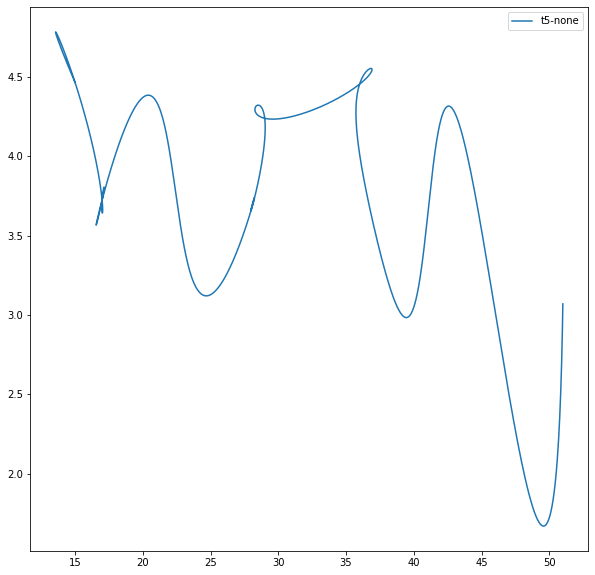

In [29]:
get_plots(scored_df, 'consistency_pred', only_model='t5')

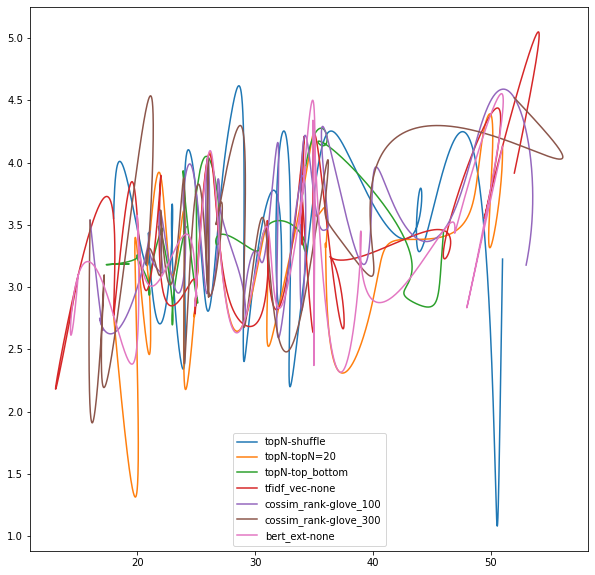

In [30]:
# get plots for all extractive models for relevance
get_plots(scored_df, 'relevance_pred')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

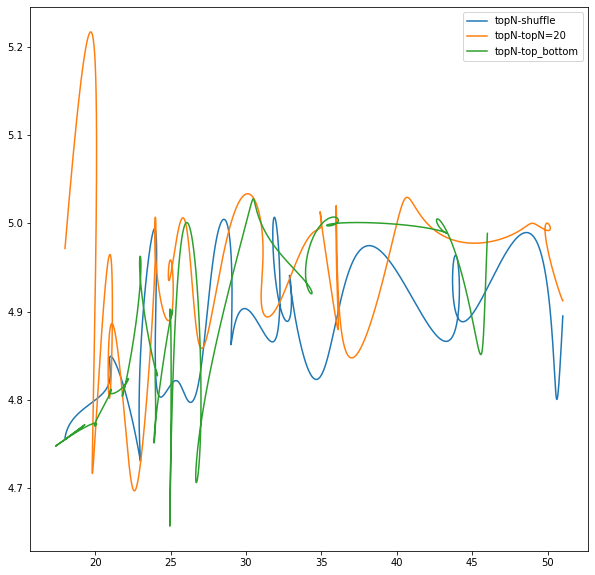

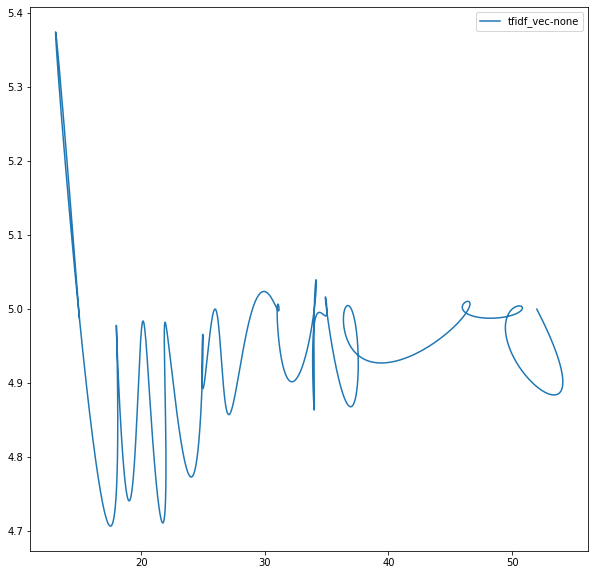

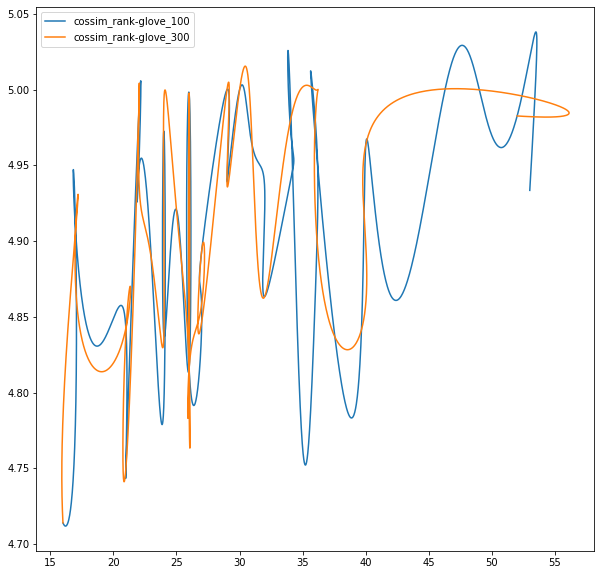

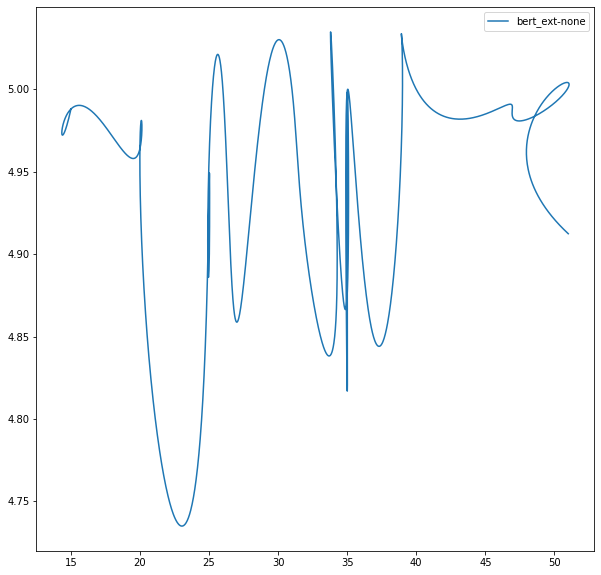

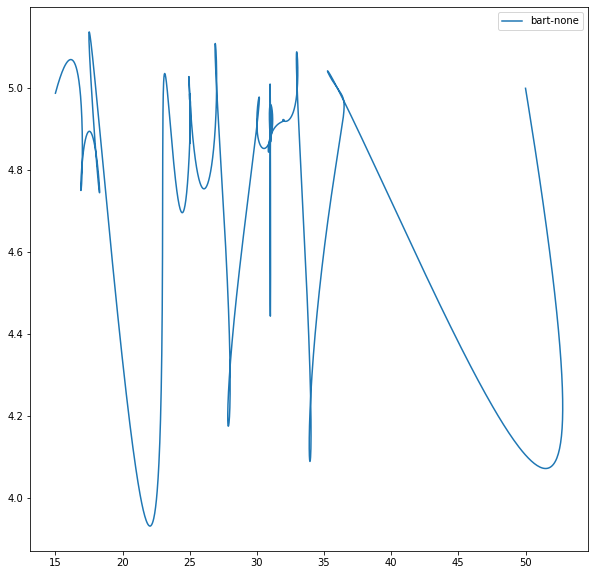

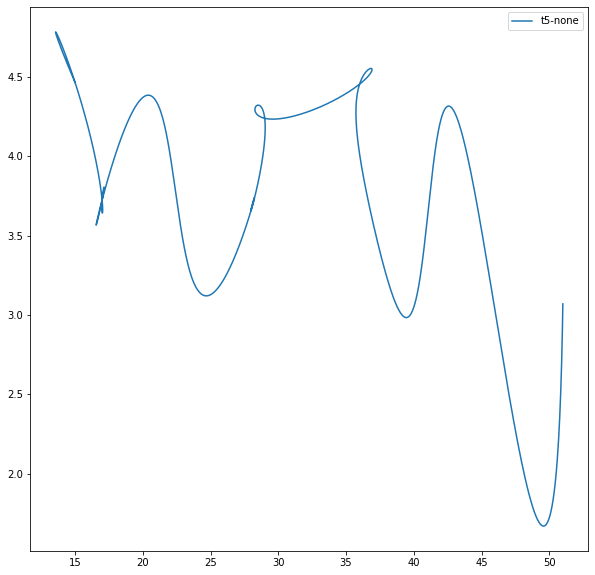

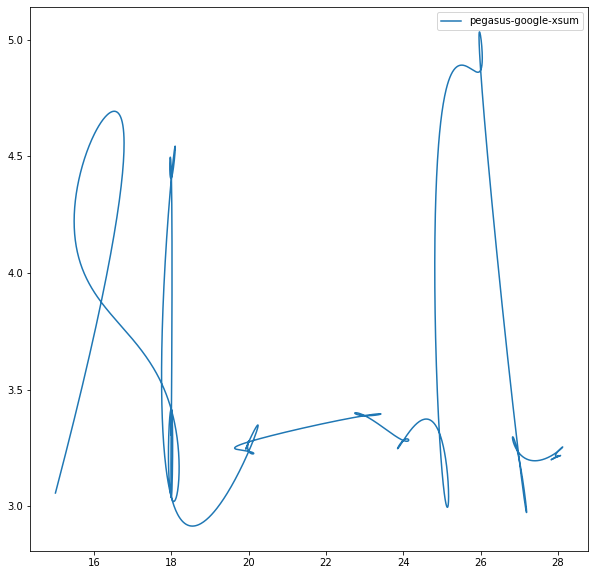

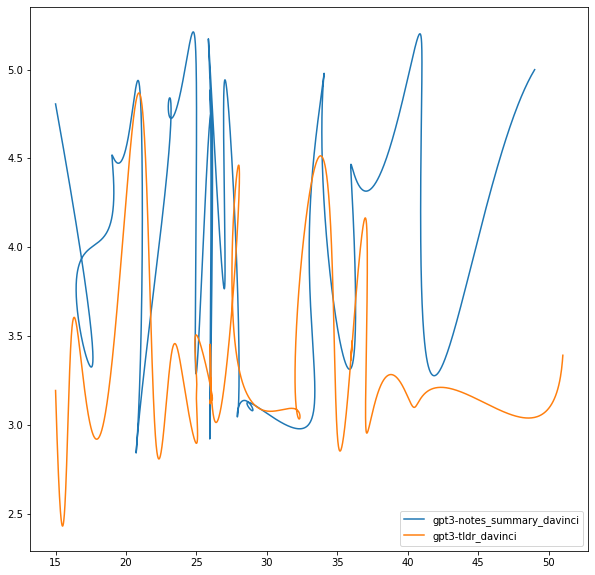

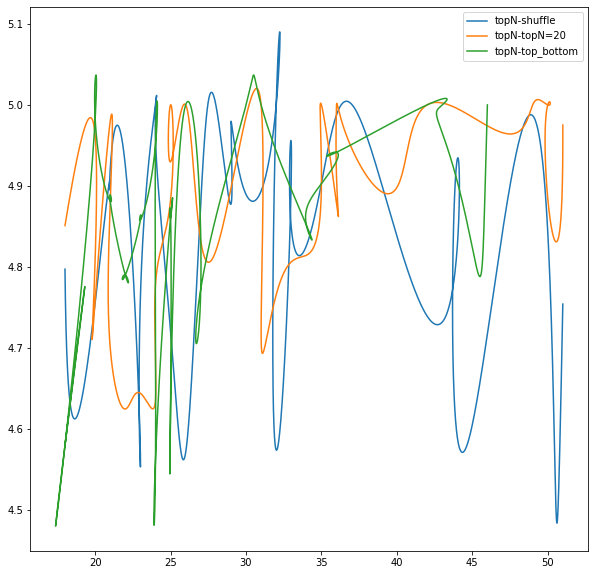

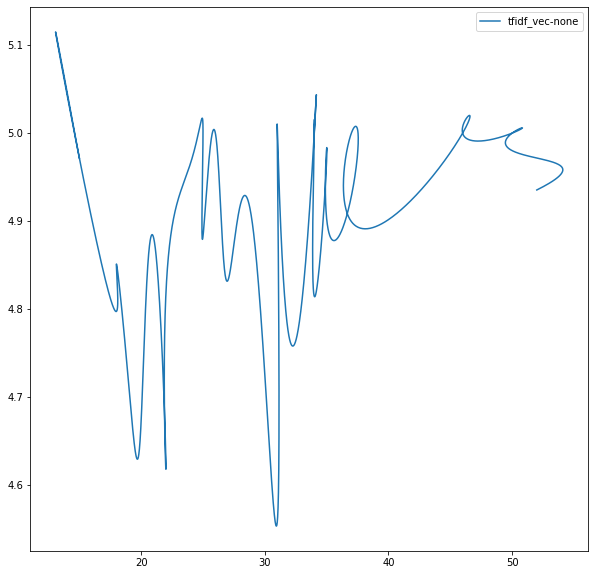

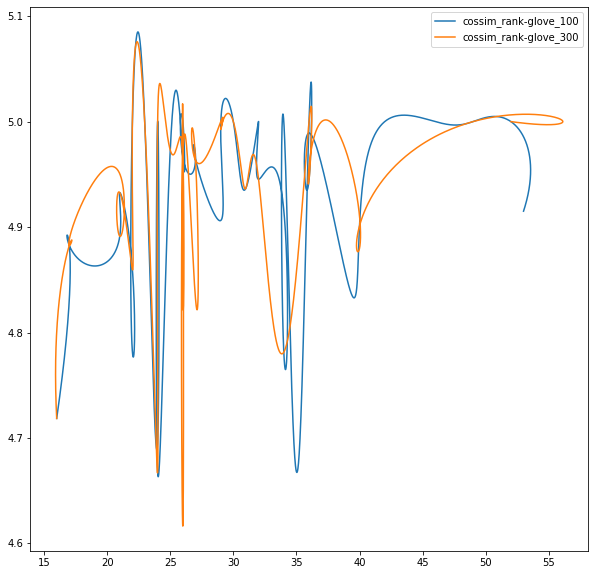

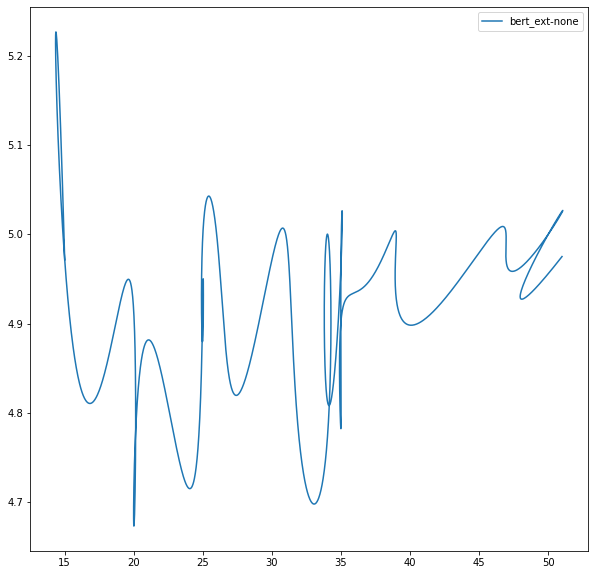

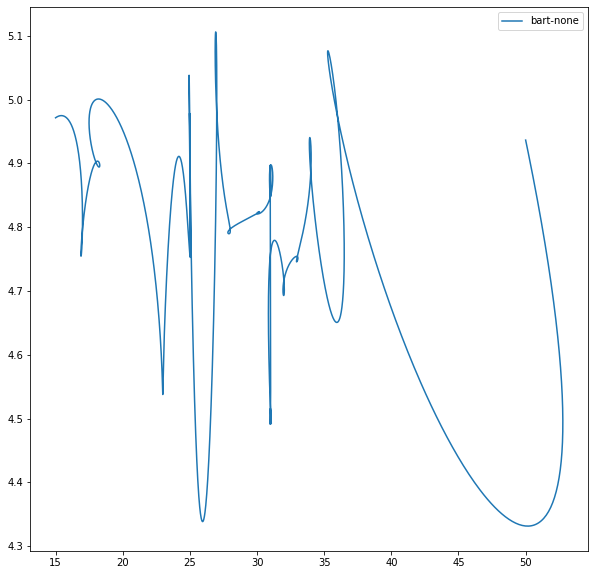

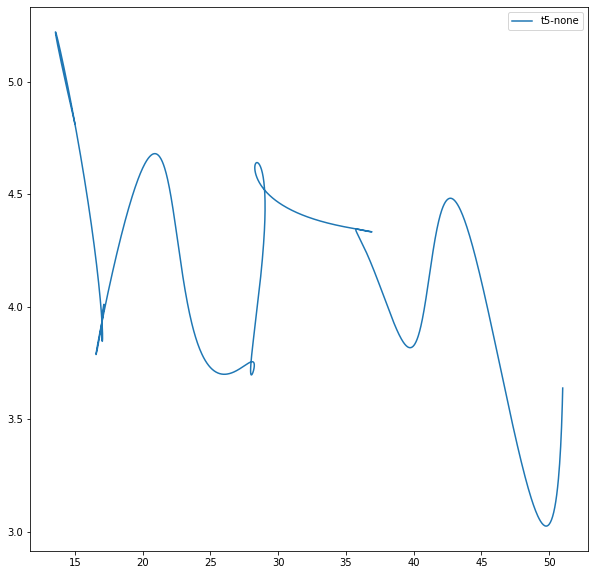

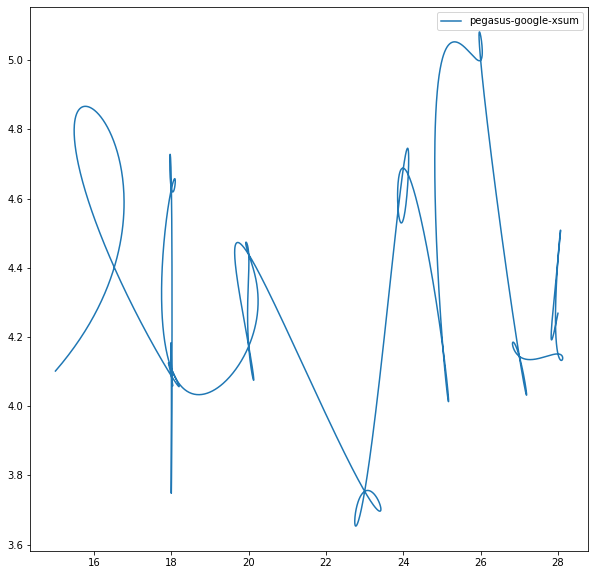

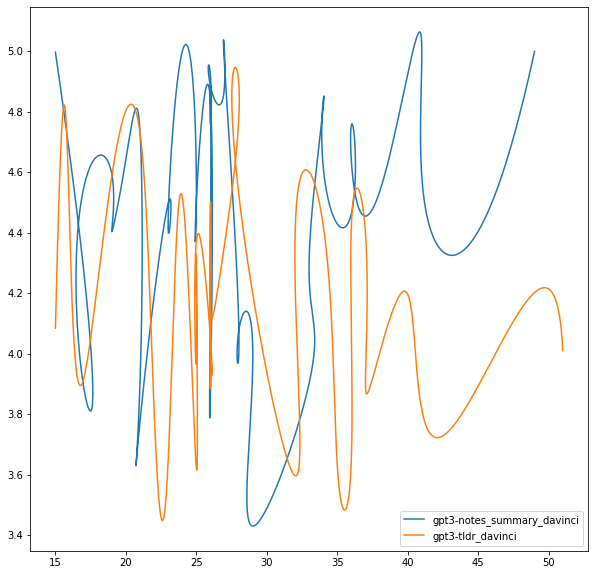

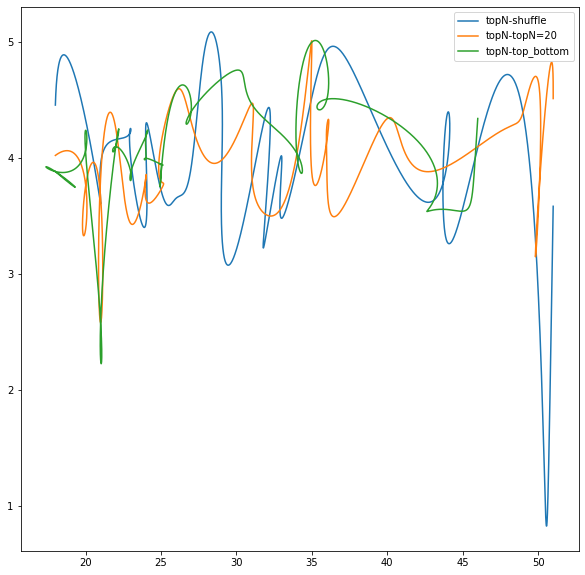

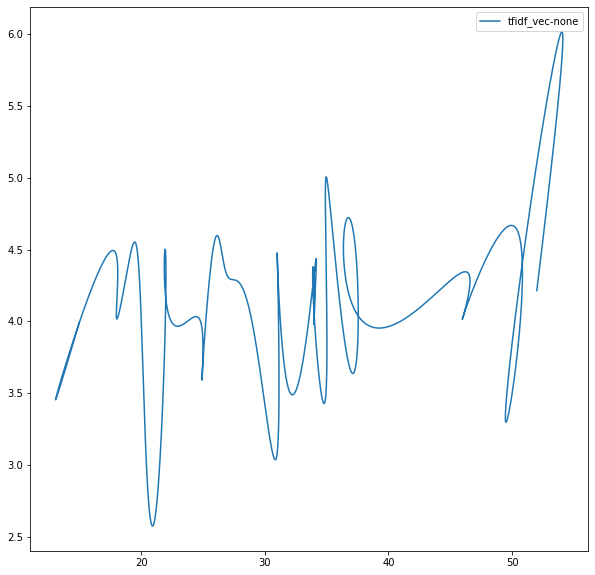

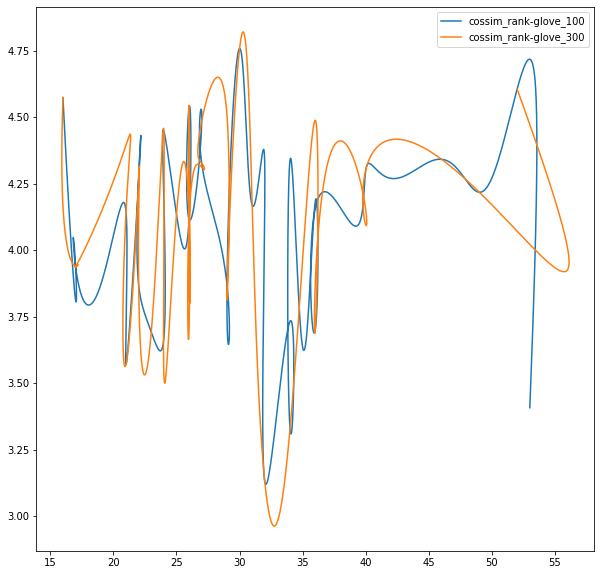

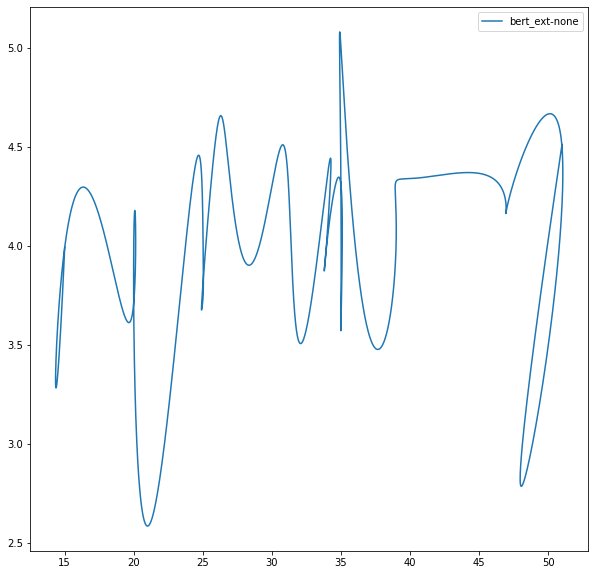

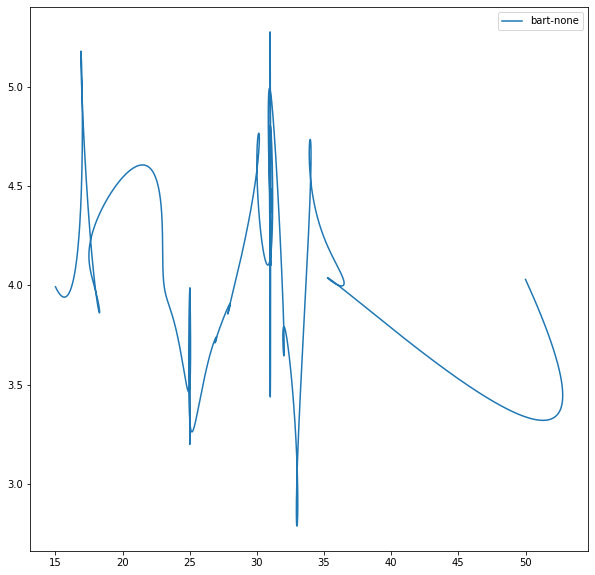

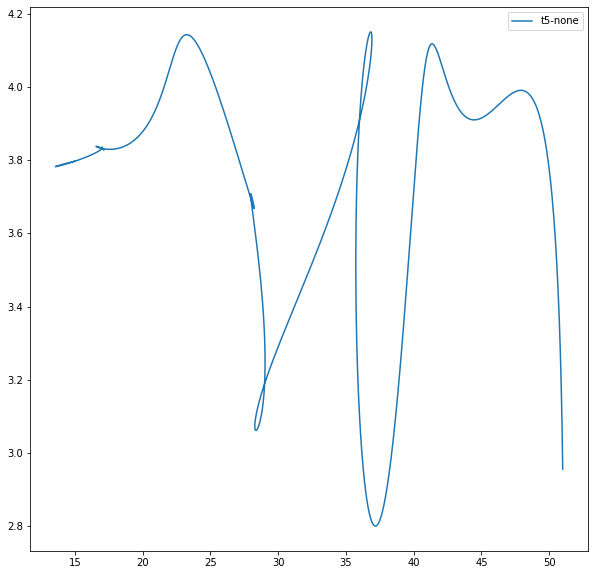

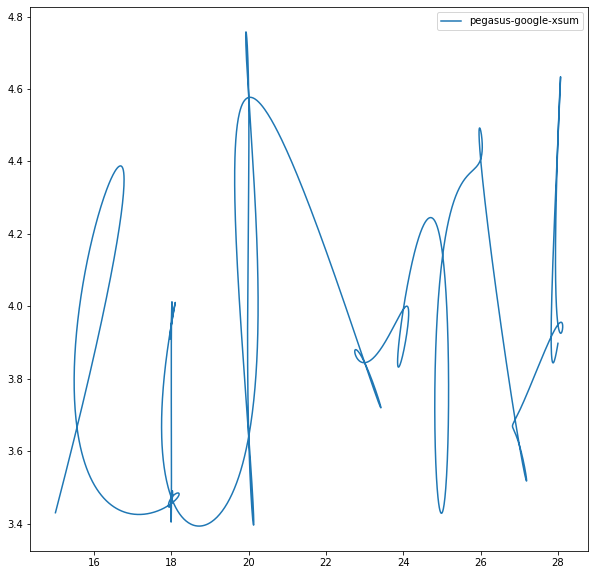

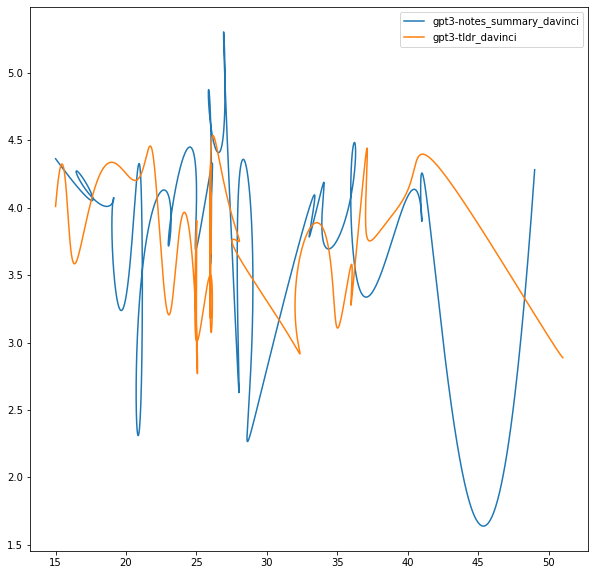

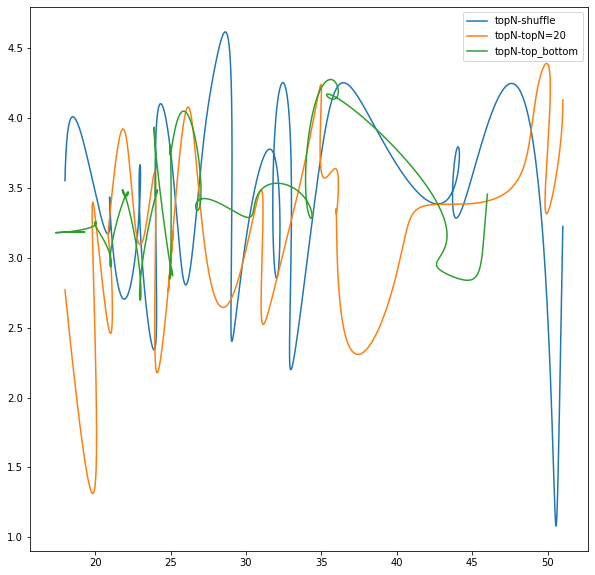

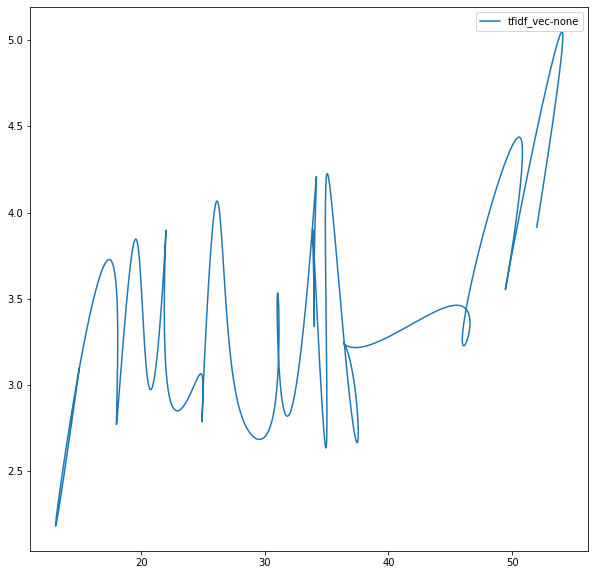

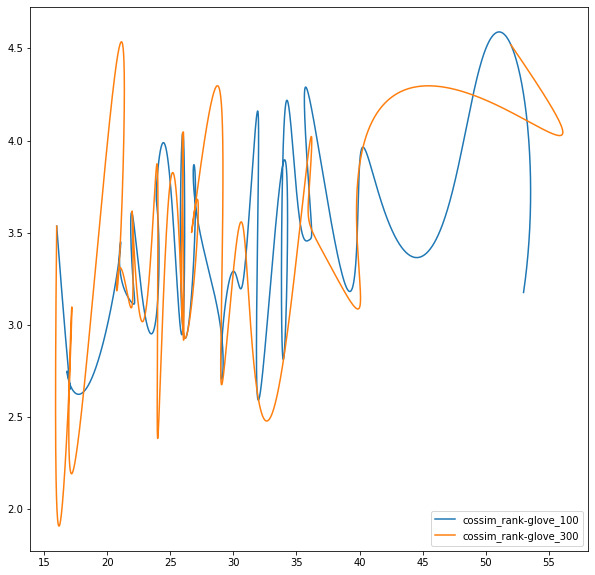

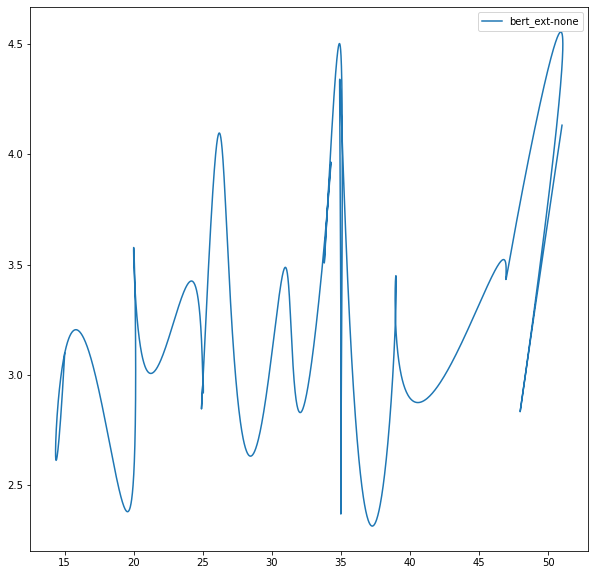

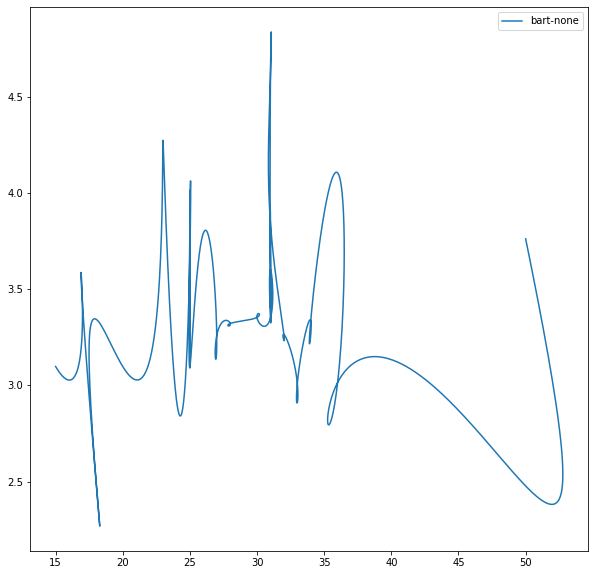

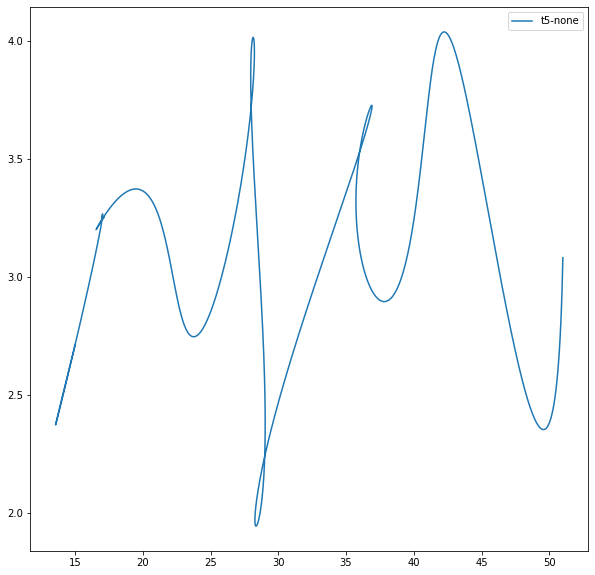

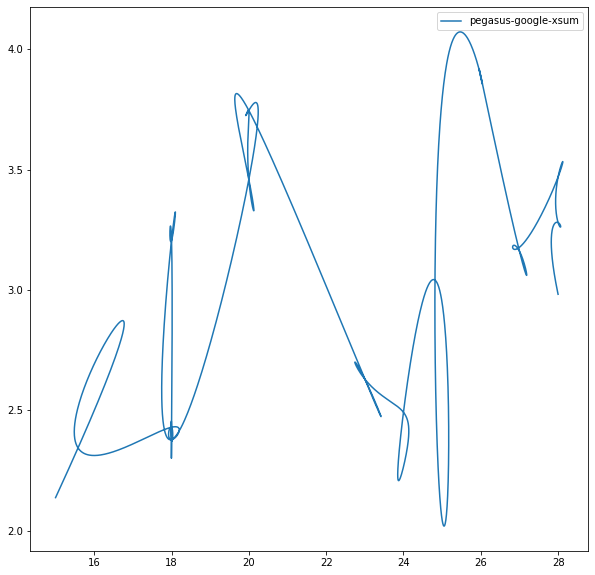

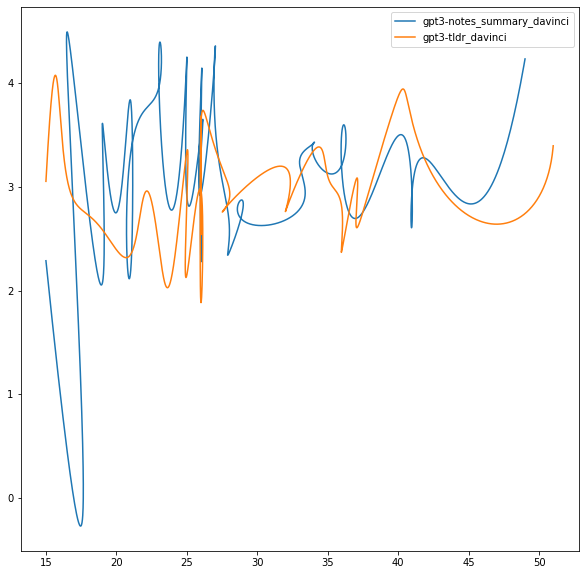

In [32]:
dims = ['consistency', 'fluency', 'coherence', 'relevance']
for d in dims:
  for m in extractive + abstractive:
    get_plots(scored_df, '{}_pred'.format(d), only_model=m, save_img=True)

In [34]:
# zip and download images
!zip images.zip /content/*.png

  adding: content/bart-coherence.png (deflated 17%)
  adding: content/bart-consistency.png (deflated 13%)
  adding: content/bart-fluency.png (deflated 14%)
  adding: content/bart-relevance.png (deflated 17%)
  adding: content/bert_ext-coherence.png (deflated 15%)
  adding: content/bert_ext-consistency.png (deflated 15%)
  adding: content/bert_ext-fluency.png (deflated 16%)
  adding: content/bert_ext-relevance.png (deflated 14%)
  adding: content/cossim_rank-coherence.png (deflated 10%)
  adding: content/cossim_rank-consistency.png (deflated 9%)
  adding: content/cossim_rank-fluency.png (deflated 11%)
  adding: content/cossim_rank-relevance.png (deflated 10%)
  adding: content/gpt3-coherence.png (deflated 11%)
  adding: content/gpt3-consistency.png (deflated 9%)
  adding: content/gpt3-fluency.png (deflated 9%)
  adding: content/gpt3-relevance.png (deflated 12%)
  adding: content/pegasus-coherence.png (deflated 12%)
  adding: content/pegasus-consistency.png (deflated 16%)
  adding: conte